Found 2352 images belonging to 2 classes.
Found 2381 images belonging to 2 classes.
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - accuracy: 0.6764 - loss: 0.5357 - val_accuracy: 0.4998 - val_loss: 4.2718 - learning_rate: 0.0010
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.9732 - loss: 0.0922 - val_accuracy: 0.5006 - val_loss: 4.4223 - learning_rate: 0.0010
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.9851 - loss: 0.0506 - val_accuracy: 0.5006 - val_loss: 4.5062 - learning_rate: 0.0010
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9923 - loss: 0.0396 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.9923 - loss: 0.0352 - val_accuracy: 0.5006 - val_loss: 4.3966 - learning_rate: 0.0010
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.9911 - loss: 0.0289 - val_accuracy: 0.5002 - val_loss: 4.6013 - learning_rate: 5.0000

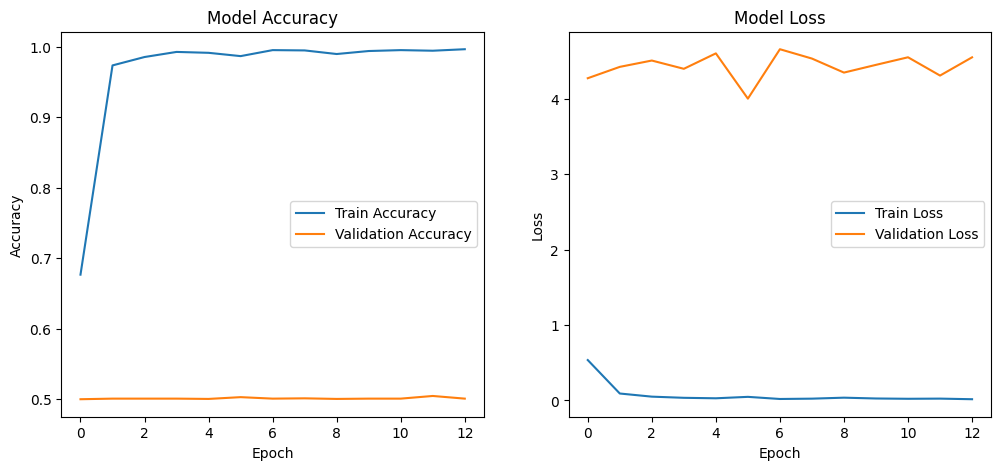

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step


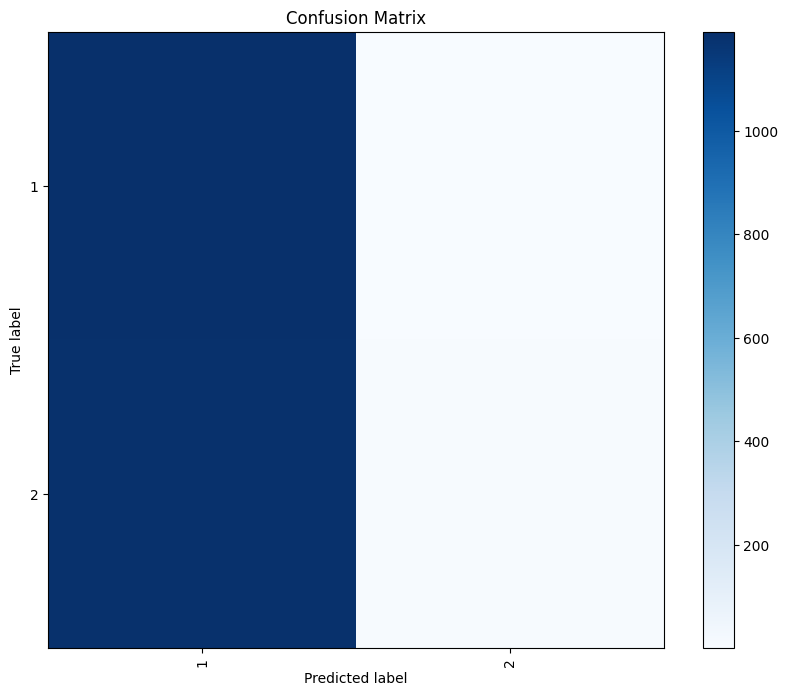

              precision    recall  f1-score   support

           1       0.50      1.00      0.67      1192
           2       0.86      0.01      0.01      1189

    accuracy                           0.50      2381
   macro avg       0.68      0.50      0.34      2381
weighted avg       0.68      0.50      0.34      2381

Macro F1 Score: 0.3390043836531193
Micro F1 Score: 0.502729945401092
Weighted F1 Score: 0.3394188787461522
Macro Precision: 0.6794138885545793
Macro Recall: 0.5021036655923143


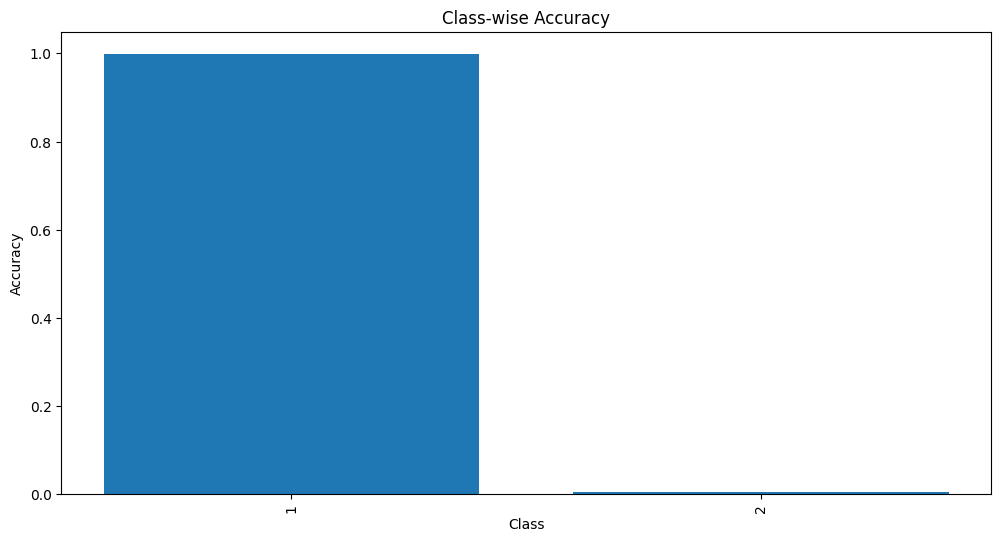

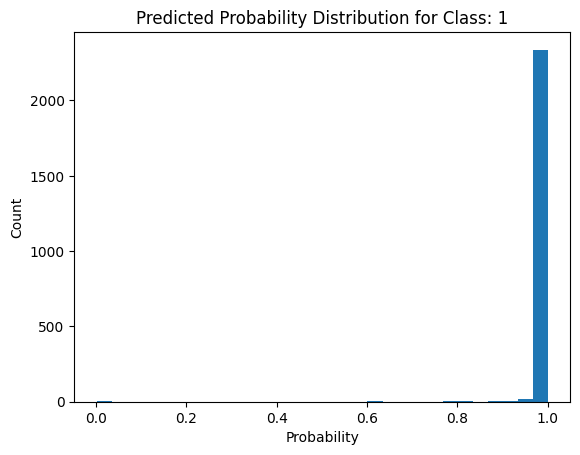

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score

# Dataset directories
train_dir = r"C:\Users\cherisma\OneDrive\Desktop\IIIT-HW-Telugu\TeluguSeg\train"
val_dir = r"C:\Users\cherisma\OneDrive\Desktop\IIIT-HW-Telugu\TeluguSeg\val"

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# Model architecture
inputs = Input(shape=(*IMG_SIZE, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Reshape((1, 128))(x)
x = LSTM(64, dropout=0.5, recurrent_dropout=0.5)(x)
x = Dropout(0.5)(x)
outputs = Dense(train_gen.num_classes, activation='softmax')(x)
rnn_model = Model(inputs, outputs)

# Compile model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = rnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

# Plot training history graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predict on validation set
val_gen.reset()
Y_pred = rnn_model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=np.arange(len(val_gen.class_indices)), labels=list(val_gen.class_indices.keys()), rotation=90)
plt.yticks(ticks=np.arange(len(val_gen.class_indices)), labels=list(val_gen.class_indices.keys()))
plt.show()

# Classification report
target_names = list(val_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# Detailed metrics
print("Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1 Score:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("Macro Precision:", precision_score(y_true, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_true, y_pred, average='macro'))

# Per-class accuracy histogram
class_accuracies = []
for i in range(len(target_names)):
    idx = np.where(y_true == i)
    class_acc = accuracy_score(y_true[idx], y_pred[idx])
    class_accuracies.append(class_acc)

plt.figure(figsize=(12, 6))
plt.bar(target_names, class_accuracies)
plt.title("Class-wise Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)
plt.show()

# Predicted probabilities histogram for first class (example)
plt.hist(Y_pred[:, 0], bins=30)
plt.title(f"Predicted Probability Distribution for Class: {target_names[0]}")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()